<a href="https://colab.research.google.com/github/lmichan/BIOliteraturaPE203625/blob/main/Enlace_con_Zotero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An√°lisis de la Biblioteca Zotero - Biolog√≠a 2025

Este cuaderno de Google Colab fue desarrollado por Jos√© Antonio Hern√°ndez Mondrag√≥n como parte del proyecto PAPIME PE203625.

El prop√≥sito principal de este c√≥digo es realizar un an√°lisis detallado de la biblioteca Zotero correspondiente al curso de Biolog√≠a 2025, con el fin de extraer informaci√≥n relevante, identificar patrones de uso, tem√°ticas predominantes y apoyar la toma de decisiones en la gesti√≥n y mejora de los recursos bibliogr√°ficos disponibles.

A lo largo del cuaderno se implementan herramientas de procesamiento de datos, visualizaci√≥n y an√°lisis bibliom√©trico para obtener una visi√≥n integral del contenido y estructura de la biblioteca Zotero.

## Conexi√≥n entre Zotero y Google Colab

Para realizar el an√°lisis de la biblioteca de Zotero desde Google Colab, es necesario establecer una conexi√≥n entre ambas plataformas utilizando la Zotero Web API. Esta API permite acceder a colecciones, referencias, metadatos y otros recursos almacenados en una cuenta o grupo de Zotero, lo cual facilita el procesamiento automatizado de los datos.

## Requisitos de configuraci√≥n

Antes de comenzar el an√°lisis, es necesario contar con dos elementos clave:

* Zotero API Key

* Group ID (en caso de trabajar con una biblioteca de grupo)

### 1. Zotero API Key

La API Key es una clave personal que otorga permisos para acceder a la biblioteca Zotero de forma segura. Para obtenerla, sigue estos pasos:

* Accede a tu cuenta en Zotero.org.

* Ve a Settings > Feeds/API.

* En la secci√≥n de API Keys, haz clic en Create new private key.

* Define los permisos de acceso (por ejemplo, lectura) y copia la clave generada.

* Esta clave se utilizar√° en el c√≥digo para autenticar las solicitudes a la API.

### 2. Group ID

Si est√°s trabajando con una biblioteca de grupo, tambi√©n necesitas el identificador √∫nico del grupo. Para obtenerlo:

* Ingresa al sitio de Zotero y selecciona tu grupo.

* El Group ID se encuentra en la URL del grupo. Por ejemplo, en: https://www.zotero.org/groups/1234567/nombre_del_grupo

* El n√∫mero 1234567 es el Group ID que deber√°s usar.


In [136]:
# CONFIGURA TU CLAVE Y GROUP ID

import requests
from collections import defaultdict, Counter
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import random

# Si es necesario se instala la libreria.
# !pip install wordcloud matplotlib
!pip install pyspellchecker

# CONFIGURA TU CLAVE Y GROUP ID (Estos se obtienen en Zotero)
API_KEY = "l7nkDwrKLxASVprKSjbadbXs"
GROUP_ID = "5866354"
HEADERS = {"Zotero-API-Key": API_KEY}


In [137]:
API_KEY = "l7nkDwrKLxASVprKSjbadbXs"  # Tu clave
GROUP_ID = "5866354"
HEADERS = {"Zotero-API-Key": API_KEY}

items = []
url = f"https://api.zotero.org/groups/{GROUP_ID}/items?limit=100"

while url:
    response = requests.get(url, headers=HEADERS)
    if response.status_code != 200:
        print("‚ùå Error:", response.status_code)
        break

    data = response.json()
    if not data:
        break

    for item in data:
        if "data" in item:
            d = item["data"]
            tags = [t["tag"] for t in d.get("tags", [])]

            items.append({
                "titulo": d.get("title"),
                "fecha_publicacion": d.get("date"),  # üëà Usa el a√±o o fecha de publicaci√≥n real
                "tipo": d.get("itemType"),
                "etiquetas": tags,
                "fecha": d.get("dateAdded") # üëà Correcci√≥n aqu√≠ para usar la fecha de adici√≥n
            })

    # Manejo de paginaci√≥n autom√°tica
    if "Link" in response.headers:
        links = response.headers["Link"].split(",")
        next_link = None
        for link in links:
            if 'rel="next"' in link:
                next_link = link[link.find("<")+1:link.find(">")]
        url = next_link
    else:
        url = None

# Crear DataFrame
df = pd.DataFrame(items)

La paleta de colores utilizada para este trabajo es Okabe-Ito fue propuesta por Okabe e Ito (2008) como una paleta de colores cualitativa accesible para personas con diversas deficiencias en la visi√≥n del color. Adem√°s de ser accesible, incluye nueve colores vivos y f√°ciles de identificar, que corresponden a los principales colores primarios y secundarios (p. ej., rojo, amarillo y azul).

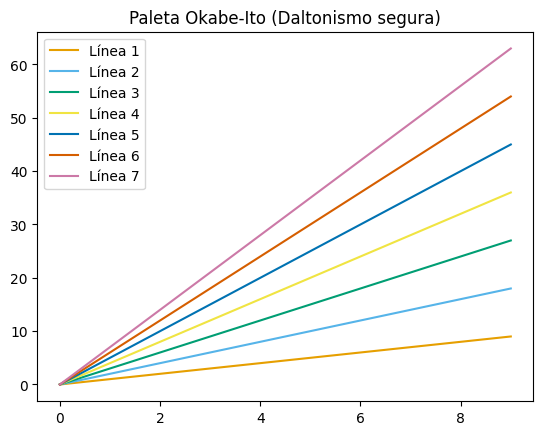

In [138]:
okabe_ito = [
    "#E69F00", # Orange
    "#56B4E9", # Sky Blue
    "#009E73", # Bluish Green
    "#F0E442", # Yellow
    "#0072B2", # Blue
    "#D55E00", # Vermilion
    "#CC79A7"  # Reddish Purple
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=okabe_ito)

for i in range(7):
    plt.plot(range(10), [j*(i+1) for j in range(10)], label=f"L√≠nea {i+1}")
plt.legend()
plt.title("Paleta Okabe-Ito (Daltonismo segura)")
plt.show()

## Gr√°fico de lineas publicaciones biblioteca por d√≠a.

Este c√≥digo genera una gr√°fica de l√≠nea que muestra c√≥mo van aumentando las publicaciones en tu biblioteca de Zotero a lo largo del tiempo.

Resumen de lo que se visualiza en la gr√°fica:

* Eje X (horizontal): las fechas (cada d√≠a en que se a√±adieron referencias a Zotero).
* Eje Y (vertical): la cantidad de publicaciones a√±adidas en esa fecha.
* Cada punto representa el n√∫mero de √≠tems incorporados en un d√≠a espec√≠fico.
* La l√≠nea une esos puntos, mostrando la tendencia temporal en la incorporaci√≥n de referencias.
* Se incluyen marcadores y cuadr√≠cula, lo que facilita identificar picos (d√≠as con muchas publicaciones) y periodos con baja o nula actividad.

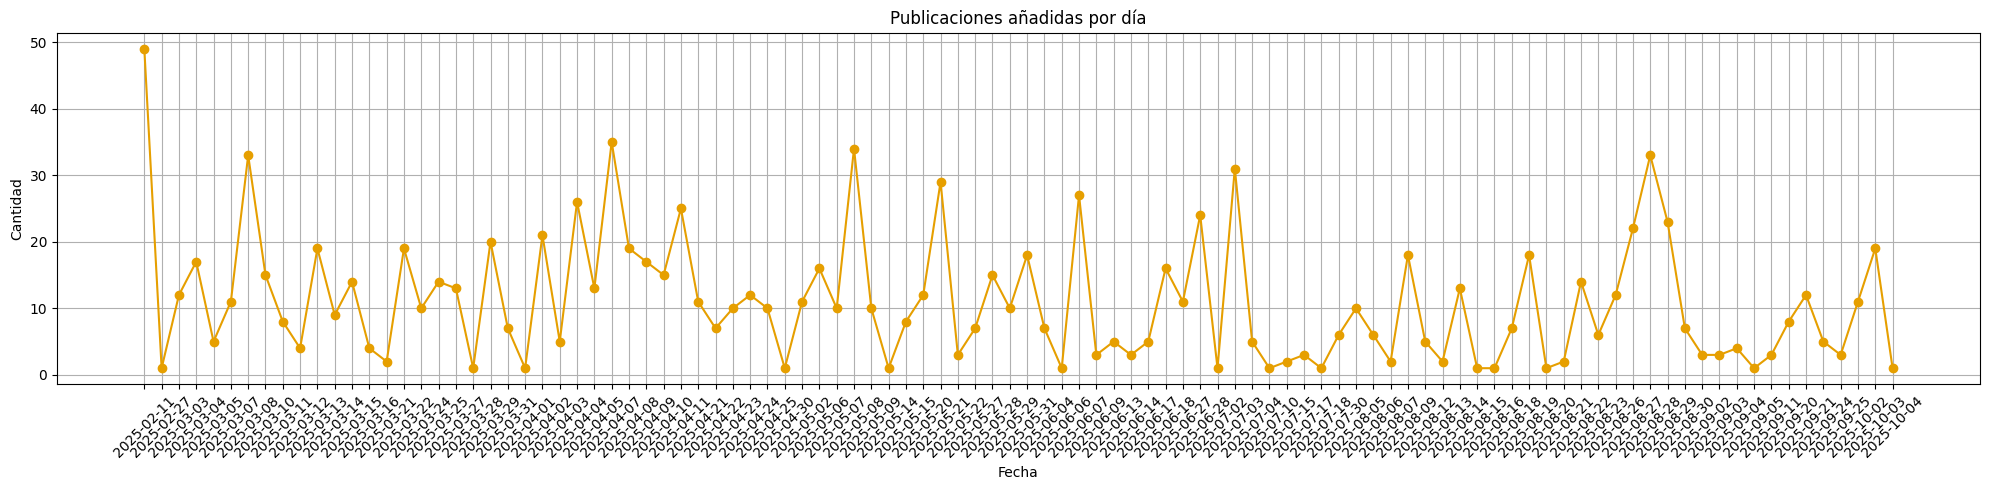

In [139]:
df = pd.DataFrame(items)
df["fecha"] = pd.to_datetime(df["fecha"])

# Agrupar por d√≠a
conteo_por_dia = df.groupby(df["fecha"].dt.date).size().reset_index(name="Total_Publicaciones")

# Opcional: convertir fechas a string para exportar
conteo_por_dia["fecha"] = conteo_por_dia["fecha"].astype(str)

# Generamos la grafica de publicaciones a√±adidas por d√≠a
plt.figure(figsize=(20, 5))
plt.plot(conteo_por_dia["fecha"], conteo_por_dia["Total_Publicaciones"], marker='o')
plt.xticks(rotation=45)
plt.title("Publicaciones a√±adidas por d√≠a")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.grid(True)
plt.show()

Al agrupar las publicaciones por semana en lugar de por d√≠a, la gr√°fica se vuelve m√°s limpia y comprensible. En la visualizaci√≥n diaria se generan muchos puntos dispersos, lo que puede hacer dif√≠cil identificar tendencias claras debido a la variabilidad natural (algunos d√≠as se agregan muchas referencias y otros ninguna).

En cambio, la vista semanal suaviza esas fluctuaciones y muestra con mayor claridad los periodos de mayor o menor productividad en la incorporaci√≥n de referencias. Esto permite:

* Detectar picos semanales de trabajo en la recopilaci√≥n bibliogr√°fica.

* Observar de manera m√°s estable la tendencia general en el tiempo.

* Comparar semanas entre s√≠ para identificar patrones de actividad (por ejemplo, semanas intensivas de b√∫squeda vs. semanas m√°s tranquilas).

La visualizaci√≥n por semana reduce el ruido del d√≠a a d√≠a y resalta las tendencias globales, facilitando el an√°lisis de la evoluci√≥n de tu biblioteca Zotero.

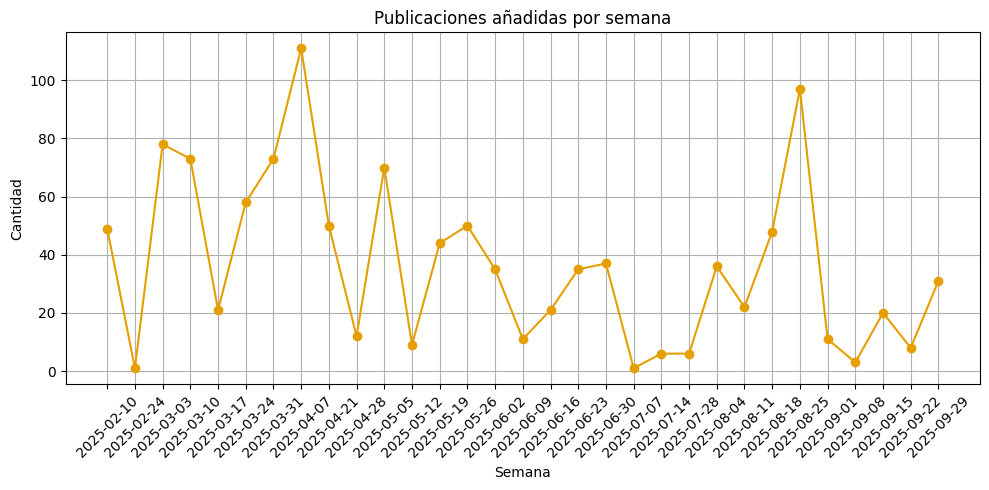

In [140]:
# Re-run the weekly graph cell to reflect the corrected 'fecha' data
# üîπ Agrupar por semana
# Convertir la columna 'fecha' a datetime si a√∫n no lo est√°
df["fecha"] = pd.to_datetime(df["fecha"])

# Eliminar la informaci√≥n de la zona horaria antes de convertir a per√≠odo
df["fecha_sin_tz"] = df["fecha"].dt.tz_convert(None) if df["fecha"].dt.tz is not None else df["fecha"]

# Agrupar por semana (esto crea objetos tipo "2025-08-04/2025-08-10")
# Usamos dt.to_period('W').dt.start_time para obtener el inicio de la semana
df["semana"] = df["fecha_sin_tz"].dt.to_period("W").dt.start_time

# üîπ Contar publicaciones por semana
conteo_semanal = df.groupby("semana").size().reset_index(name="Total_Publicaciones")

# üîπ Convertir fechas para graficar o exportar
conteo_semanal["semana_str"] = conteo_semanal["semana"].dt.strftime("%Y-%m-%d")

# Vemos la grafica a nivel semanal
plt.figure(figsize=(10, 5))
plt.plot(conteo_semanal["semana_str"], conteo_semanal["Total_Publicaciones"], marker='o')
plt.xticks(rotation=45)
plt.title("Publicaciones a√±adidas por semana")
plt.xlabel("Semana")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

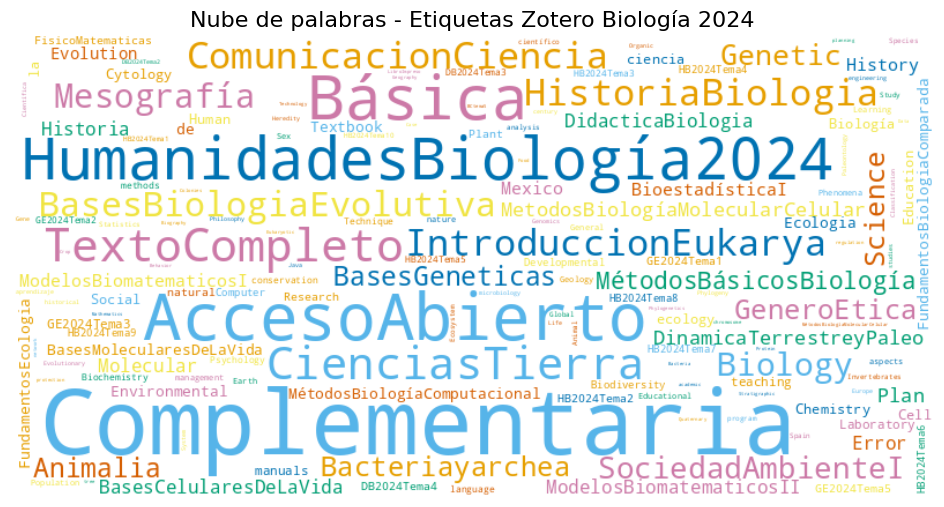

In [141]:
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(okabe_ito)

# Convertir todas las etiquetas en un solo string
text = ' '.join(all_tags)

# Crear la nube
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    color_func=color_func,
    collocations=False
).generate(text)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - Etiquetas Zotero Biolog√≠a 2024", fontsize=16)
plt.show()


Se realizo un an√°lisis de los t√≠tulos de las referencias permitiendo garantizar la calidad y coherencia de la base bibliogr√°fica. Dado que Zotero se usa frecuentemente para generar citas y bibliograf√≠as en documentos acad√©micos, los errores en los t√≠tulos (como guiones mal colocados, uso incorrecto de may√∫sculas, puntos innecesarios o faltas de ortograf√≠a) pueden trasladarse de forma autom√°tica a los art√≠culos, tesis o reportes en los que se cite la fuente.

Este proceso de revisi√≥n y limpieza tiene varias ventajas:

* Coherencia formal: asegura que todos los t√≠tulos sigan el mismo estilo de escritura, evitando inconsistencias que afectan la presentaci√≥n profesional del trabajo.

* Evitar errores en citas autom√°ticas: al corregir la ortograf√≠a y el formato, se reducen fallos al exportar bibliograf√≠as en estilos como APA, MLA o Vancouver.

* Ahorro de tiempo: una biblioteca limpia significa menos correcciones manuales al final de un proyecto.

* Mayor credibilidad acad√©mica: las referencias son parte fundamental de cualquier investigaci√≥n, y tener t√≠tulos bien escritos refleja rigurosidad y cuidado en el trabajo cient√≠fico.

En s√≠ntesis, este an√°lisis convierte la biblioteca de Zotero en una fuente depurada y confiable, lista para integrarse directamente en publicaciones sin arrastrar errores tipogr√°ficos o de estilo.

In [142]:
import pandas as pd
import re
from spellchecker import SpellChecker

# Diccionarios espa√±ol e ingl√©s
spell_es = SpellChecker(language='es')
spell_en = SpellChecker(language='en')

problemas = []

for titulo in df["titulo"].dropna():
    errores = []

    palabras = titulo.split()

    # 1. Regla APA: solo la primera palabra debe estar capitalizada (excepto nombres propios, aqu√≠ no los distinguimos)
    for i, word in enumerate(palabras):
        if i == 0:  # primera palabra
            continue
        elif word[0].isupper():  # palabra con may√∫scula inicial que no deber√≠a
            errores.append("MAY√öSCULAS APA")
            break

    # 2. Punto final
    if titulo.strip().endswith("."):
        errores.append("PUNTO FINAL APA")

    # 3. Espacios dobles
    if "  " in titulo:
        errores.append("ESPACIOS DOBLES")

    # 4. Guiones
    if "-" in titulo:
        errores.append("GUIONES")

    # 5. Corchetes
    if "[" in titulo or "]" in titulo:
        errores.append("CORCHETES")

    # 6. S√≠mbolos especiales
    if re.search(r"[@#\$%\^&\*\~\=]", titulo):
        errores.append("S√çMBOLOS ESPECIALES")

    # 7. Ortograf√≠a (es/en)
    palabras_limpias = re.findall(r'\b\w+\b', titulo.lower())
    errores_ort = []
    for p in palabras_limpias:
        if p not in spell_es and p not in spell_en:
            errores_ort.append(p)

    if len(errores_ort) >= 2:
        errores.append("ORTOGRAF√çA")

    # Guardar si hay errores
    if errores:
        problemas.append({"titulo": titulo, "errores": ", ".join(errores)})

df_errores = pd.DataFrame(problemas)
print(f"üîé T√≠tulos problem√°ticos encontrados (APA): {len(df_errores)}")
df_errores.head(10)



üîé T√≠tulos problem√°ticos encontrados (APA): 522


titulo  \
0                Non-linearity in population ecology   
1  Modelos estadisticos lineales : interpretacion...   
2  Modelos estad√≠sticos lineales: interpretaci√≥...   
3  An Analysis of Variance Test for Normality (Co...   
4  Introductory Biological Statistics: Fourth Edi...   
5                 Introducci√≥n a la bioestad√≠stica   
6  Uso correcto, parcial e incorrecto de los t√©rm...   
7                                       Estad√≠stica   
8                Dise√±o y an√°lisis de experimentos   
9  El Protocolo de investigaci√≥n: lineamientos p...   

                      errores  
0                     GUIONES  
1                  ORTOGRAF√çA  
2                  ORTOGRAF√çA  
3              MAY√öSCULAS APA  
4              MAY√öSCULAS APA  
5                  ORTOGRAF√çA  
6                  ORTOGRAF√çA  
7                  ORTOGRAF√çA  
8                  ORTOGRAF√çA  
9  MAY√öSCULAS APA, ORTOGRAF√çA

                                              titulo fecha_publicacion     a√±o
0                Non-linearity in population ecology              2014  2014.0
1                                               None              None     NaN
2  Modelos estadisticos lineales : interpretacion...              1976  1976.0
3  Modelos estad√≠sticos lineales: interpretaci√≥...              1981  1981.0
4                            Biostatistical analysis              2014  2014.0


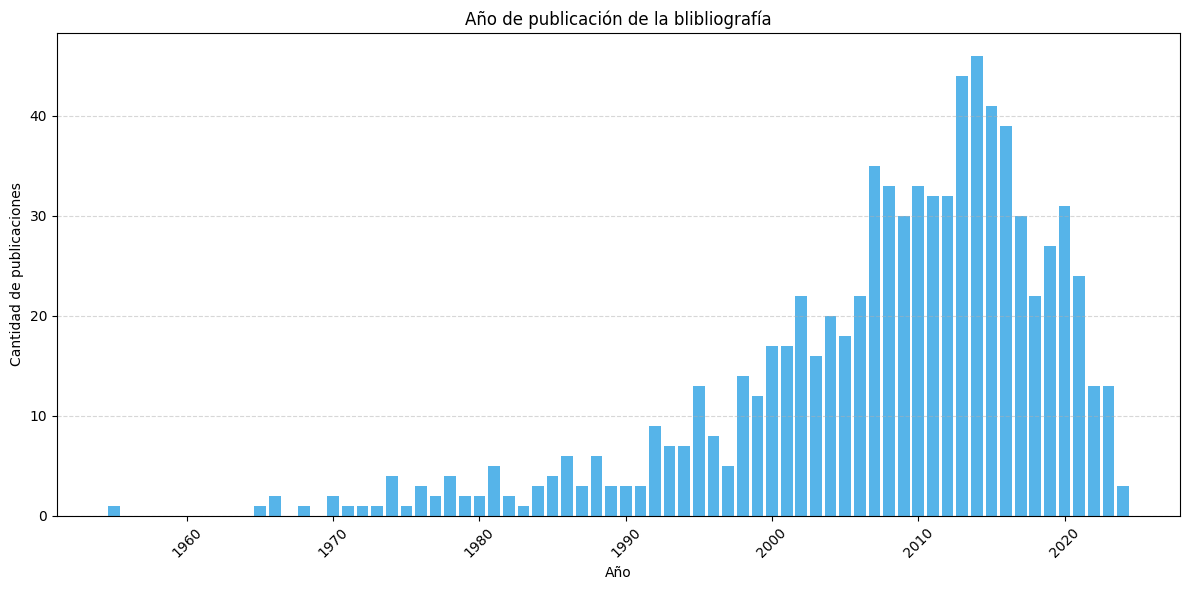

In [143]:
import re
import numpy as np

def extraer_anio(fecha_texto):
    if not isinstance(fecha_texto, str):
        return np.nan
    match = re.search(r"\b(19|20)\d{2}\b", fecha_texto)
    return int(match.group()) if match else np.nan

df["a√±o"] = df["fecha_publicacion"].apply(extraer_anio)

print(df[["titulo", "fecha_publicacion", "a√±o"]].head())

conteo_por_anio = df["a√±o"].value_counts().sort_index().reset_index()
conteo_por_anio.columns = ["A√±o", "Cantidad"]
conteo_por_anio = conteo_por_anio[conteo_por_anio["A√±o"].notnull()]  # Filtrar nulos
conteo_por_anio["A√±o"] = conteo_por_anio["A√±o"].astype(int)
conteo_por_anio

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(conteo_por_anio["A√±o"], conteo_por_anio["Cantidad"], color="#56B4E9")
plt.title("A√±o de publicaci√≥n de la blibliograf√≠a")
plt.xlabel("A√±o")
plt.ylabel("Cantidad de publicaciones")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

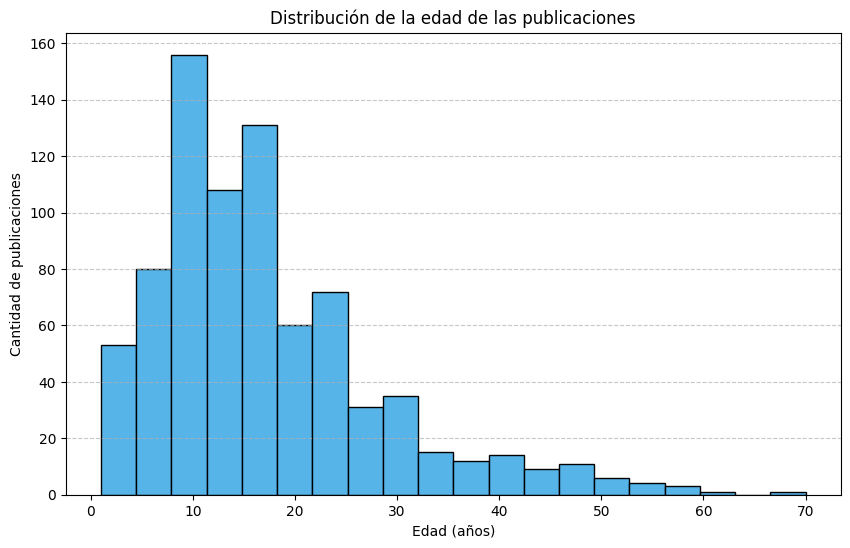

In [144]:
from datetime import datetime

anio_actual = datetime.now().year

# Filtramos filas con a√±o v√°lido y creamos una copia expl√≠cita
df_validos = df[df["a√±o"].notnull()].copy()

# Calculamos edad de cada publicaci√≥n
df_validos["edad"] = anio_actual - df_validos["a√±o"]

# Vemos los primeros (opcional, para depuraci√≥n)
# display(df_validos.head())

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df_validos["edad"], bins=20, color="#56B4E9", edgecolor="black")
plt.title("Distribuci√≥n de la edad de las publicaciones")
plt.xlabel("Edad (a√±os)")
plt.ylabel("Cantidad de publicaciones")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [145]:
# Edad promedio de la libreria.
edad_promedio = df_validos["edad"].mean()
print(f"La edad promedio de las publicaciones es de {edad_promedio:.2f} a√±os.")

La edad promedio de las publicaciones es de 17.13 a√±os.


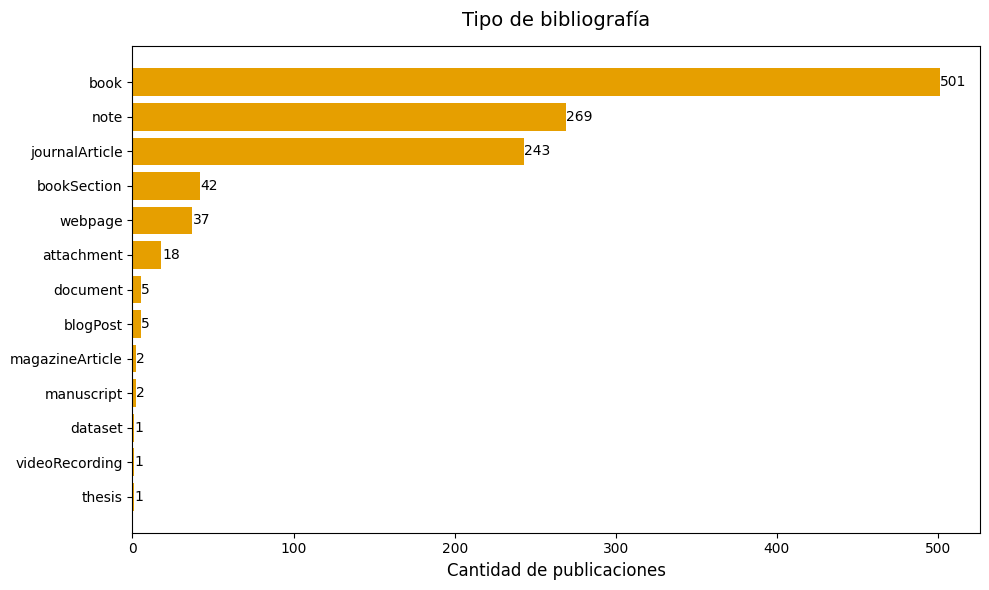

In [146]:
# ============================
# üìä Gr√°fica de barras: Tipos de √≠tems Zotero
# ============================

if "tipo" in df.columns:
    # Contar los tipos de √≠tem
    conteo_tipos = df["tipo"].value_counts().sort_values()

    # Paleta accesible (Okabe-Ito)
    okabe_ito = [
        "#E69F00"
    ]

    # Crear la gr√°fica
    plt.figure(figsize=(10, 6))
    bars = plt.barh(
        conteo_tipos.index,
        conteo_tipos.values,
        color=okabe_ito[:len(conteo_tipos)]
    )

    # Etiquetas y estilo
    plt.title("Tipo de bibliograf√≠a", fontsize=14, pad=15)
    plt.xlabel("Cantidad de publicaciones", fontsize=12)
    plt.ylabel("", fontsize=12)

    # A√±adir etiquetas de valor al final de cada barra
    for bar in bars:
        plt.text(
            bar.get_width() + 0.3,                 # posici√≥n x
            bar.get_y() + bar.get_height() / 2,    # posici√≥n y
            str(int(bar.get_width())),              # texto (conteo)
            va="center", ha="left", fontsize=10
        )

    plt.tight_layout()
    plt.show()

else:
    print("‚ö†Ô∏è No se encontr√≥ la columna 'tipo'. Aseg√∫rate de incluir item_data.get('itemType') en el diccionario.")




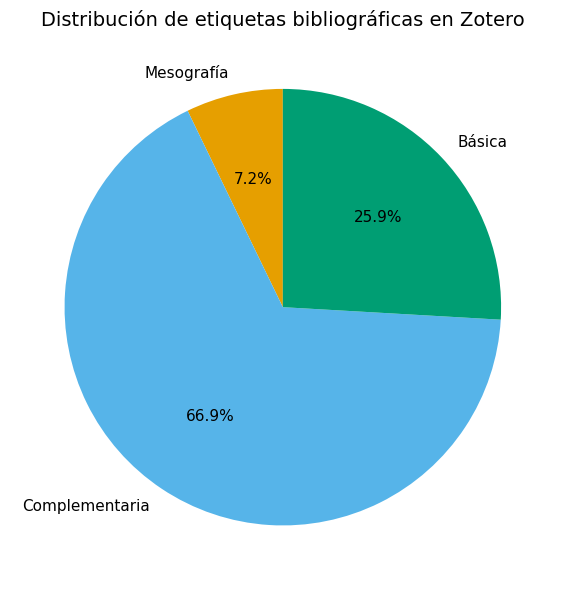

In [147]:
# ============================
# ü•ß Gr√°fica de pastel: etiquetas de tipo bibliograf√≠a
# ============================

import pandas as pd
import matplotlib.pyplot as plt

# Paleta Okabe-Ito (segura para dalt√≥nicos)
okabe_ito = [
    "#E69F00",  # Orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Bluish Green
    "#F0E442",  # Yellow
    "#0072B2",  # Blue
    "#D55E00",  # Vermilion
    "#CC79A7"   # Reddish Purple
]

# Etiquetas a analizar (sin emojis para evitar problemas de visualizaci√≥n)
etiquetas_objetivo = ["Mesograf√≠a", "Complementaria", "B√°sica"]

# Contar cu√°ntas veces aparece cada una
conteo_etiquetas = {et: 0 for et in etiquetas_objetivo}

for etiquetas in df["etiquetas"]:
    if isinstance(etiquetas, list):
        for e in etiquetas:
            # Limpiar la etiqueta de emojis antes de comparar
            cleaned_e = "".join([c for c in e if c.isalnum() or c.isspace()])
            if cleaned_e in conteo_etiquetas:
                conteo_etiquetas[cleaned_e] += 1
    elif isinstance(etiquetas, str):
        # Limpiar la etiqueta de emojis antes de comparar
        cleaned_etiquetas = "".join([c for c in etiquetas if c.isalnum() or c.isspace()])
        for et in etiquetas_objetivo:
            if et in cleaned_etiquetas:
                conteo_etiquetas[et] += 1


# Crear gr√°fica
plt.figure(figsize=(6, 6))
plt.pie(
    conteo_etiquetas.values(),
    labels=conteo_etiquetas.keys(),
    autopct="%1.1f%%",
    startangle=90,
    colors=okabe_ito[:len(conteo_etiquetas)],
    textprops={"fontsize": 11}
)
plt.title("Distribuci√≥n de etiquetas bibliogr√°ficas en Zotero", fontsize=14)
plt.tight_layout()
plt.show()